In [1]:
''' Fake News Classifier (NumPy + Pandas Only)

Python + NumPy only

Custom Text Preprocessing

TF vectorization (Bag-of-Words)

Two-Layer Neural Network

Adam Optimizer

Binary Classification (Fake vs Real)

Dataset: Kaggle Fake News Dataset (Fake.csv + True.csv)'''


' Fake News Classifier (NumPy + Pandas Only)\n\nPython + NumPy only\n\nCustom Text Preprocessing\n\nTF vectorization (Bag-of-Words)\n\nTwo-Layer Neural Network\n\nAdam Optimizer\n\nBinary Classification (Fake vs Real)\n\nDataset: Kaggle Fake News Dataset (Fake.csv + True.csv)'

In [ ]:
import pandas as pd
import numpy as np
import re
import string
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df_fake = pd.read_csv('/content/Fake.csv')
df_true = pd.read_csv('/content/True.csv')

df_true['label'] = 1
df_fake['label'] = 0

df = pd.concat([df_true,df_fake]).reset_index(drop = True)

def clean(text): #this is a function to clean up the text  remove the commas and stops etc
  if isinstance(text, str):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = text.translate(str.maketrans("","",string.punctuation))
    text = re.sub(r"\s",' ', text).strip()
    return text
  return ''

df['content'] = (df['title'].fillna('')+' '+ df['text'].fillna('')).apply(clean)
df =  df[['content','label']]
print(df.columns)

Index(['content', 'label'], dtype='object')


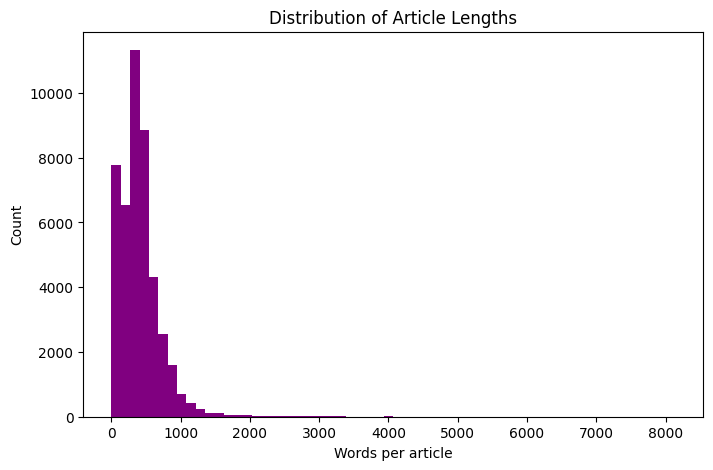

In [ ]:
df["length"] = df["content"].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,5))
plt.hist(df["length"], bins=60, color="purple")
plt.title("Distribution of Article Lengths")
plt.xlabel("Words per article")
plt.ylabel("Count")
plt.show()

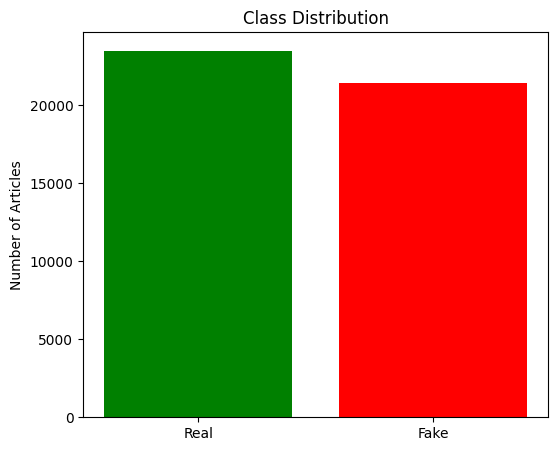

In [ ]:
plt.figure(figsize=(6,5))
plt.bar(["Real", "Fake"], [np.sum(df["label"]==0), np.sum(df["label"]==1)], color=["green","red"])
plt.title("Class Distribution")
plt.ylabel("Number of Articles")
plt.show()

In [ ]:
word_counts = Counter()
for text in df['content']:
  words = text.split()

  word_counts.update(words)

  bigrams = [words[i] + " " + words[i+1] for i in range(len(words)-1)]
  word_counts.update(bigrams)


  trigrams = [words[i] + " " + words[i+1] + " " + words[i+2] for i in range(len(words)-2)]
  word_counts.update(trigrams)

vocab = [w for w,c in word_counts.most_common(10000)]
word_ids = {w:i for i, w in enumerate(vocab)}
V  = len(vocab)
vocab[:10]

['the', 'to', 'of', 'a', 'and', 'in', 'that', 'on', 'for', 's']

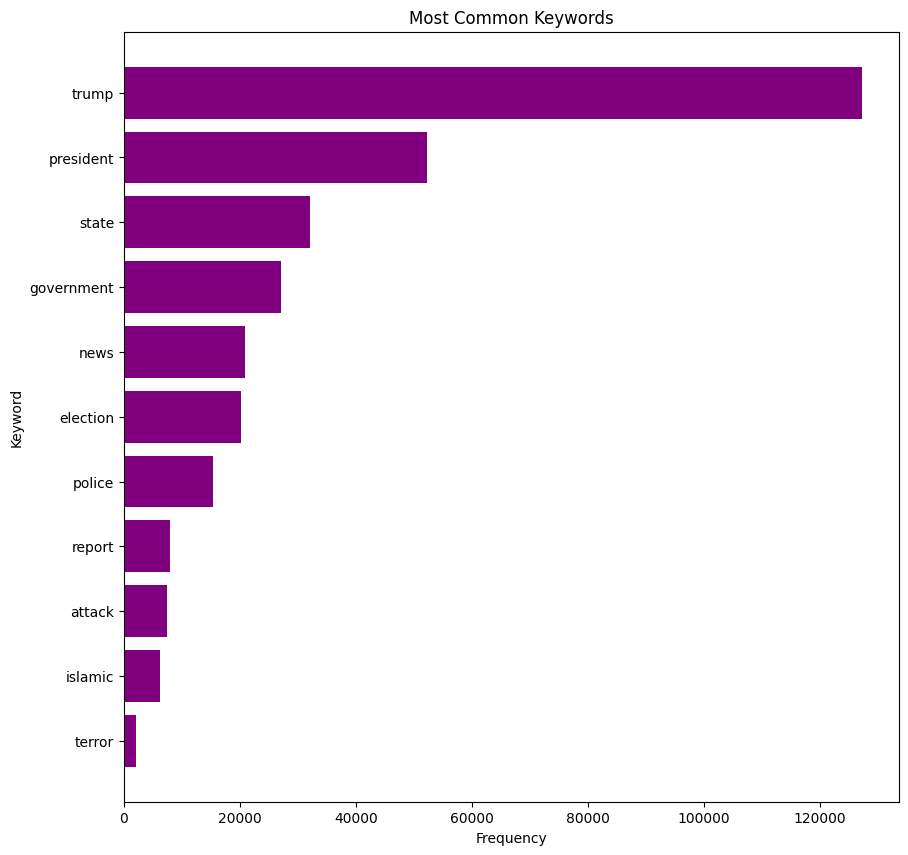

In [ ]:
imp_words = ['trump','news','government','election','attack',
'president','police','islamic','state','report','terror']

counts_imp ={}

for w in imp_words:
  counts_imp[w] = word_counts[w]

sorted_items = sorted(counts_imp.items(), key=lambda x: x[1], reverse=True)

words = [w for w, c in sorted_items]
counts = [c for w, c in sorted_items]

plt.figure(figsize=(10,10))
plt.barh(words, counts, color="purple")
plt.gca().invert_yaxis()  # so highest count is on top
plt.xlabel("Frequency")
plt.ylabel("Keyword")
plt.title("Most Common Keywords")
plt.show()


In [ ]:
def tf_vector(text):#to make a vector of words with counts
  vec = np.zeros(V)
  words = text.split()

  for w in words:
    if w in word_ids:
      vec[word_ids[w]] +=1

  for i in range(len(words)-1):
    bg = words[i] + ' ' + words[i+1]
    if bg in word_ids:
      vec[word_ids[bg]] += 1
  return vec


In [ ]:
X = np.array([tf_vector(t) for t in df['content']])
y = df['label'].values

In [ ]:
np.random.seed(42)
indices = np.arange(len(X))
np.random.shuffle(indices)

X = X[indices]
y = y[indices]

split = int(0.8 * len(X))

X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]


In [ ]:
def sigmoid(z):
  z = np.clip(z, -50, 50)
  return 1/(1+np.exp(-z))

def relu(z):
  return np.maximum(0,z)

def relu_deriv(z):
  return (z>0).astype(float)

In [ ]:
def train_nn(X, y, lr=0.001, epochs=30, h1 = 128,h2=64,beta1=0.9,beta2=0.999,eps=1e-8):

    n,input_dim = X.shape
    W1 = np.random.randn(input_dim, h1)*np.sqrt(2/input_dim)
    b1 = np.zeros((1,h1))
    W2 = np.random.randn(h1,h2)*np.sqrt(2/h1)
    b2 = np.zeros((1,h2))
    W3 = np.random.randn(h2,1)*np.sqrt(2/h2)
    b3 = np.zeros((1,1))

    y = y.reshape(-1,1)

    params = [W1,b1,W2,b2,W3,b3]
    m = [np.zeros_like(p) for p in params]
    v = [np.zeros_like(p) for p in params]

    t = 0

    for epoch in range(epochs):
        t+=1

        z1 = X@W1 + b1
        A1 = relu(z1)

        z2 = A1@W2 + b2
        A2 = relu(z2)

        z3 = A2@W3 + b3
        A3 = sigmoid(z3)

        loss = -np.mean(y*np.log(A3 + eps)+(1-y)*np.log(1-A3 + eps))

        dz3 = A3 - y
        dW3 = A2.T@dz3/n
        db3 = np.mean(dz3, axis=0, keepdims=True)

        dA2 = dz3@W3.T
        dz2 = dA2*relu_deriv(z2)
        dW2 = A1.T@dz2/n
        db2 = np.mean(dz2, axis=0, keepdims=True)

        dA1 = dz2 @ W2.T
        dz1 = dA1 * relu_deriv(z1)
        dW1 = X.T @ dz1/n
        db1 = np.mean(dz1, axis=0, keepdims=True)

        grads = [dW1,db1,dW2,db2,dW3,db3]

        for i in range(len(params)):
          m[i] = beta1*m[i] + (1-beta1)*grads[i]
          v[i] = beta2*v[i] + (1-beta2)*(grads[i]**2)

          m_hat = m[i]/(1-beta1**t)
          v_hat = v[i]/(1-beta2**t)

          params[i] -= lr*m_hat/(np.sqrt(v_hat)+eps)

        W1, b1, W2, b2, W3, b3 = params


        print(f"epoch {epoch}: loss {loss}")

    return W1, b1, W2, b2, W3, b3



In [ ]:
W1,b1,W2,b2,W3,b3 = train_nn(X_train,y_train,lr=0.001,epochs=30)

epoch 0: loss 0.6675759925209205
epoch 1: loss 0.4902098124183478
epoch 2: loss 0.3634953399530062
epoch 3: loss 0.2852611209306055
epoch 4: loss 0.20195683130258368
epoch 5: loss 0.18445409916745142
epoch 6: loss 0.1749406447595555
epoch 7: loss 0.1467117388496655
epoch 8: loss 0.12018689895500881
epoch 9: loss 0.10695651227459722
epoch 10: loss 0.10248321343909883
epoch 11: loss 0.09499717553298737
epoch 12: loss 0.08274498461595667
epoch 13: loss 0.07175509493041156
epoch 14: loss 0.06533008978208901
epoch 15: loss 0.061921742235425285
epoch 16: loss 0.05804773059814995
epoch 17: loss 0.052275924433458305
epoch 18: loss 0.046093821625655035
epoch 19: loss 0.04132957041223374
epoch 20: loss 0.03833388404124954
epoch 21: loss 0.03622091086163587
epoch 22: loss 0.03370286413122653
epoch 23: loss 0.0306029870249282
epoch 24: loss 0.027560162058189935
epoch 25: loss 0.025233595650843585
epoch 26: loss 0.023522689290722484
epoch 27: loss 0.022076847746508817
epoch 28: loss 0.0205480823732

In [ ]:
probs = sigmoid(relu(relu(X_test @ W1 + b1) @ W2 + b2)@W3 + b3)
pred = (probs >= 0.5).astype(int).flatten()

acc = np.mean(pred == y_test)
print("Accuracy:", acc)



Accuracy: 0.9934298440979955


In [ ]:
SENSATIONAL_WORDS = [
    "shocking", "secretly", "exposed", "leaked", "breaking",
    "unbelievable", "claims", "allegedly", "funds",
    "terrorist", "scandal", "insider", "reveals",
    "plot", "scheme", "agenda", "hidden",
    "sources", "anonymous", "secret", "coverup",
    "massive", "disaster", "destroy", "fraud", "rigged"
]

def sensationalism_score(tokens):
    return sum(w in SENSATIONAL_WORDS for w in tokens) / max(1, len(tokens))



In [ ]:
ACCUSATION_VERBS = [
    "funds", "supports", "backs", "finances", "helped",
    "created", "runs", "leads", "controls"
]

ACCUSATION_OBJECTS = [
    "terrorist", "terrorists", "terrorism", "extremist", "extremists",
    "cartel", "criminal", "attack", "massacre"
]

def accusation_score(tokens):
    score = 0
    for i in range(len(tokens)-1):
        if tokens[i] in ACCUSATION_VERBS and tokens[i+1] in ACCUSATION_OBJECTS:
            score += 1
    return score


In [ ]:
OFFICIAL_SOURCES = [
    "fbi", "cia", "police", "government", "officials",
    "investigators", "ministry", "department", "court",
    "report", "reports", "agency", "intelligence", "spokesperson"
]

def has_official_source(tokens):
    return any(w in OFFICIAL_SOURCES for w in tokens)


In [ ]:
def style_score(text):
    words = text.split()
    avg_word_len = sum(len(w) for w in words) / len(words)
    caps = sum(w.isupper() for w in words)

    score = 0
    if avg_word_len < 4: score += 1
    if caps > 0: score += 1
    return score


In [ ]:
def predict(text):
    text = clean(text)
    if len(text.split()) < 5:
        return "Input too short for reliable classification"

    vec = tf_vector(text)
    vec = vec.reshape(1,-1)

    z1 = vec @ W1 + b1
    A1 = relu(z1)

    z2 = A1 @ W2 + b2
    A2 = relu(z2)

    z3 = A2 @ W3 + b3
    prob = float(sigmoid(z3))


    print(prob)
    return "FAKE NEWS" if prob <= 0.5 else "REAL NEWS"


def final_classifier(text):
    tokens = clean(text)


    nn_label = predict(text)


    sens = sensationalism_score(tokens)
    acc = accusation_score(tokens)
    official = has_official_source(tokens)
    style = style_score(text)


    if acc > 0 and not official:
        return "LIKELY FAKE (unsupported accusation)"

    if sens > 0.04 and nn_label == "REAL NEWS":
        return "LIKELY FAKE (sensational tone)"

    if style > 1 and nn_label == "REAL NEWS":
        return "LIKELY FAKE (dramatic writing)"

    if nn_label == "FAKE NEWS":
        return "FAKE NEWS"

    if acc > 0 and official:
        return "REAL NEWS (official accusation)"


    return nn_label


text = "Trump secretly funds terrorist organizations, reports leaked online"

print(final_classifier(text))
print(final_classifier('FBI arrests man suspected of planning attack, officials confirm'))
print(final_classifier('Prime Minister meets with EU leaders to discuss trade agreement'))
print(final_classifier('WHO issues updated guidelines on emerging health risks'))


0.3664219408109138
FAKE NEWS
0.42093151710252935
FAKE NEWS
0.6600447436661622
REAL NEWS
0.5224336278604987
REAL NEWS


/tmp/ipython-input-353998578.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prob = float(sigmoid(z3))


In [ ]:
def confusion_matrix(true, pred):
    tp = np.sum((true==1) & (pred==1))
    tn = np.sum((true==0) & (pred==0))
    fp = np.sum((true==0) & (pred==1))
    fn = np.sum((true==1) & (pred==0))
    return np.array([[tn, fp], [fn, tp]])

cm = confusion_matrix(y_test, pred)
print(cm)


[[4602   33]
 [  26 4319]]


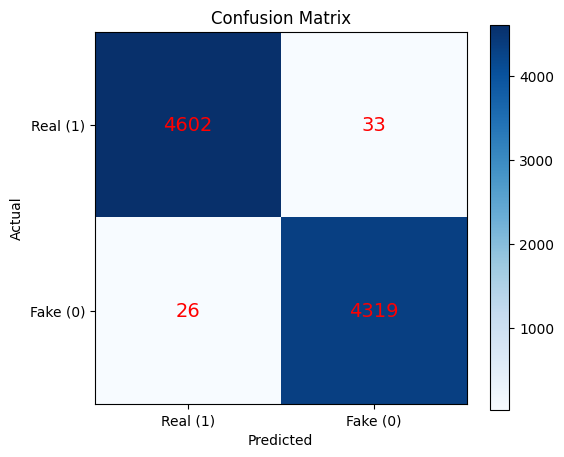

In [ ]:

plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()

classes = ["Real (1)", "Fake (0)"]
tick_marks = np.arange(len(classes))

plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.xlabel("Predicted")
plt.ylabel("Actual")

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red', fontsize=14)

plt.show()

In [ ]:
'''Accuracy achieved: 0.993

Implemented fully from scratch using only NumPy + Pandas.'''
